In [1]:
import torch
import torch.nn as nn
import numpy as np

In [2]:
from matplotlib import pyplot
from pprint import pprint
%matplotlib inline

In [3]:
def computeY(X, sigma) :
    mu = 0 
    return np.cos(2*np.pi*X) + (sigma*np.random.randn(X.size,1)+mu)

In [4]:
def getData(N, sigma):
    #np.random.seed(40)
    X = np.random.uniform(low=0,high=1.0,size=(N,1))
    #X = torch.sort(X).values
    Y = computeY(X, sigma)
    X = torch.tensor(X,dtype=torch.float32)
    Y = torch.tensor(Y,dtype=torch.float32)
    return X, Y

In [5]:
def createNbyDPolynomial(X,N,d):
    XPoly = torch.ones((N,d+1))
    for i in range(N):
        for j in range(1,d+1):
            XPoly[i,j] = X[i]**j
    return XPoly

In [6]:
def getXY(X,Y,N,d):
    XPoly = createNbyDPolynomial(X,N,d)
    return XPoly, Y

In [7]:
def getTrainingData(XPoly, Y):
    indexes = np.arange(N)
    np.random.shuffle(indexes)
    
    trainingDataSize = int(len(X) * 0.8)
    if trainingDataSize == 0 :
        trainingDataSize = 1
    
    trainingIndexes = indexes[:trainingDataSize]
    valIndexes = indexes[trainingDataSize:]

    XTrain, YTrain = XPoly[trainingIndexes], Y[trainingIndexes]
    XVal, YVal = XPoly[valIndexes], Y[valIndexes]
    
    return XTrain, YTrain, XVal, YVal, trainingIndexes

In [8]:
def getMSE(Y, Ybar) :
    error = Y-Ybar
    mse =  error ** 2
    return mse.mean(), error

In [9]:
def getMSEReg(Y,Ybar,theta,reg):
    error = Y-Ybar
    errSquared = error ** 2
    mse =  errSquared.mean()
    sumThetaSq = torch.sum(theta**2, dim=0)
    mseReg = mse + (reg*sumThetaSq)
    return mseReg, error

In [10]:
def computeMiniBatchGrad(batchSize, error, XTrain):
    trainingIndexes = np.arange(len(XTrain))
    # shuffle indexes so we aren't picking the same training samples
    np.random.shuffle(trainingIndexes)
    # take a [batchSize] of the training indexes and 
    batchIndexes = trainingIndexes[:batchSize]
    XSGD, ErrSGD = XTrain[batchIndexes], error[batchIndexes]
    grad = -2 * torch.mm(torch.t(XSGD), ErrSGD)
    #grad = -2 * torch.mm(XSGD.reshape(-1,1), ErrSGD)
    # we can't take the mean of the gradient here because the summation has already happened in the matrix multiplication
    # all we need to do is divide the individual values by the batch size
    return grad/batchSize

In [11]:
def updateParams(theta, lrate, grad):
    return theta - (lrate * grad)

In [12]:
def updateParamsReg(theta,lrate,grad,reg):
    gradReg = 2*reg*theta
    return theta - (lrate * (grad+gradReg))

In [13]:
def initTheta(d) :
    # The bias b is absorbed into theta as b(knot) and 1 is absorbed into X as X(knot)
    # start with d+1 randomly generated normal distribution
    theta = torch.tensor(np.random.uniform(low=0,high=1.0,size=(d+1,1)),dtype=torch.float32)#assuming d = 2. will become d+1
    return theta

In [40]:
# should be plotting the MSE vs number of runs : run till convergence
def fit(XTrain,YTrain,d,reg):
    prevMSE = 0
    currentMSE = 0
    lrate = 1e-1
    theta = initTheta(d)
    N = len(XTrain)
    
    for i in range(5000):
        # set previous mean squared error to current mean squared error
        prevMSE = currentMSE
        # calculate the estimated Y(bar) using there and X train
        Ybar = torch.mm(XTrain,theta)
        # calculate the mean squared error between true Y and estimated Y
        currentMSE, err = getMSEReg(YTrain, Ybar, theta, reg)
        # compute mini batch stochastic gradient descent
        gradient = computeMiniBatchGrad(int(0.5*N), err, XTrain)
        # update the parameters of theta using the old theta, the learning rate and the gradient
        theta = updateParamsReg(theta, lrate, gradient, reg)
        
    return currentMSE, theta
        

In [25]:
def runTest(testN,sigma,d,theta,reg):
    X,Y = getData(testN,sigma)
    XTest, YTest = getXY(X,Y,testN,d)
    YTestbar = torch.mm(XTest,theta)
    mse, YTestErr = getMSEReg(YTest,YTestbar,theta,reg)
    return X,YTest,YTestbar,YTestErr,mse

In [26]:
def fitData(XTrain,YTrain,N,d,sigma,reg=False):
    #eIns, epochs, theta = fit(XTrain,YTrain,d)
    eIn, theta = fit(XTrain,YTrain,d,reg)
    X,YTest,YTestbar,YTestErr,eOut = runTest(1500,sigma,d,theta,reg)
    return theta, eIn, eOut

In [37]:
def experiment(N,d,sigma,reg) :
    trials = 50
    eIns = torch.empty(trials,1,dtype=torch.float32)
    eOuts = torch.empty(trials,1,dtype=torch.float32)
    thetas = torch.empty(trials,d+1,dtype=torch.float32)
    for i in range(trials):
        X,Y = getData(N,sigma)
        XTrain, YTrain = getXY(X,Y,N,d)
        theta, eIn, eOut = fitData(XTrain,YTrain,N,d,sigma,reg)
        #print(eIn,eOut,theta)
        #thetas[i], eIns[i], eOuts[i] = theta.reshape(-1,1), eIn, eOut
        thetas[i], eIns[i], eOuts[i] = torch.t(theta), eIn, eOut
    eIn, eOut = np.nanmean(eIns.numpy()), np.nanmean(eOuts.numpy())
    # find mean over each column
    thetaNP = np.nanmean(thetas.numpy(),axis=0)
    theta = torch.tensor(thetaNP)
    theta = theta.reshape(-1,1)
    # initialize size of testN
    X,YTest,YTestbar,YTestErr,eBias = runTest(1500,sigma,d,theta,reg)
    
    return X, YTest, YTestbar, eIn, eOut, eBias

In [18]:
# setting reg to True means activating regularization - weight decay
def experimentResult(N,d,sigma,reg) :
    X,Y,YBar,eIn,eOut,eBias = experiment(N,d,sigma,reg)
    print(f"Combination : {[N,d,sigma]} \t Training Error : {eIn} \t Testing Error : {eOut} \t Bias : {eBias}")
     #'''
    pyplot.scatter(X.numpy(),Y.numpy())
    pyplot.plot(X,YBar,'ro')
    pyplot.legend(['Estimated', 'Original'])
    #'''
    return eIn,eOut,eBias

Combination : [100, 10, 0.01] 	 Training Error : 0.011164247989654541 	 Testing Error : 0.01168133970350027 	 Bias : tensor([0.0110])


(0.011164248, 0.01168134, tensor([0.0110]))

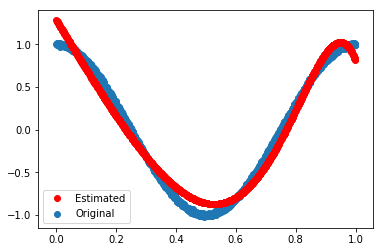

In [41]:
experimentResult(100,10,0.01,0)

Combination : [100, 10, 0.01] 	 Training Error : 0.009532730095088482 	 Testing Error : 0.010419744066894054 	 Bias : tensor([0.0098])


(0.00953273, 0.010419744, tensor([0.0098]))

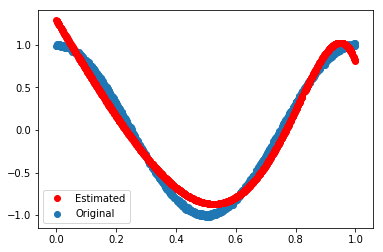

In [42]:
experimentResult(100,10,0.01,-2e-5)

In [31]:
NList = [2,5,10,20,50,100,200]
dList = np.arange(0,21)
sigmas = [0.01,0.1,1]
#print(NList,dList, sigma)

In [34]:
def runExperiments(reg):
    results = []
    for N in NList:
        for d in dList:
            for sigma in sigmas:
                X,Y,YBar,eIn,eOut,eBias = experiment(N,d,sigma,reg)
                print(f"Combination : {[N,d,sigma]} \t Training Error : {eIn} \t Testing Error : {eOut} \t Bias : {eBias.numpy()[0]}")
                results.append([N,d,sigma,eIn.item(),eOut.item(),eBias.item()])

    with open (f"./results/experiments_weight_decay_{reg}",'w', encoding="utf-8") as f:
        pprint(results, f)         

In [43]:
runExperiments(0)

Combination : [2, 0, 0.01] 	 Training Error : 0.25792500376701355 	 Testing Error : 0.7636798024177551 	 Bias : 0.5051800012588501
Combination : [2, 0, 0.1] 	 Training Error : 0.33477678894996643 	 Testing Error : 0.7657434344291687 	 Bias : 0.5091174840927124
Combination : [2, 0, 1] 	 Training Error : 0.7425971031188965 	 Testing Error : 2.49637508392334 	 Bias : 1.5850638151168823
Combination : [2, 1, 0.01] 	 Training Error : 0.0005109591875225306 	 Testing Error : 2.417997360229492 	 Bias : 0.910211443901062
Combination : [2, 1, 0.1] 	 Training Error : 0.0012652634177356958 	 Testing Error : 2.109513282775879 	 Bias : 0.7706151604652405
Combination : [2, 1, 1] 	 Training Error : 0.06212767958641052 	 Testing Error : 8.951481819152832 	 Bias : 1.5535603761672974
Combination : [2, 2, 0.01] 	 Training Error : 0.0002620956802275032 	 Testing Error : 2.829159736633301 	 Bias : 0.9559311270713806
Combination : [2, 2, 0.1] 	 Training Error : 0.0017078624805435538 	 Testing Error : 2.452364

Combination : [5, 0, 0.01] 	 Training Error : 0.3938078284263611 	 Testing Error : 0.6331223845481873 	 Bias : 0.4844590127468109
Combination : [5, 0, 0.1] 	 Training Error : 0.4175359308719635 	 Testing Error : 0.6678957939147949 	 Bias : 0.5147755146026611
Combination : [5, 0, 1] 	 Training Error : 1.147326946258545 	 Testing Error : 1.8228949308395386 	 Bias : 1.521433711051941
Combination : [5, 1, 0.01] 	 Training Error : 0.2124982327222824 	 Testing Error : 1.2338440418243408 	 Bias : 0.5729553699493408
Combination : [5, 1, 0.1] 	 Training Error : 0.23467344045639038 	 Testing Error : 1.228480577468872 	 Bias : 0.5769867897033691
Combination : [5, 1, 1] 	 Training Error : 0.8749386072158813 	 Testing Error : 3.2653281688690186 	 Bias : 1.5314031839370728
Combination : [5, 2, 0.01] 	 Training Error : 0.029269900172948837 	 Testing Error : 0.8519132733345032 	 Bias : 0.2062472403049469
Combination : [5, 2, 0.1] 	 Training Error : 0.04070150852203369 	 Testing Error : 0.7370592355728

Combination : [10, 0, 0.01] 	 Training Error : 0.4385792016983032 	 Testing Error : 0.5386006832122803 	 Bias : 0.514893651008606
Combination : [10, 0, 0.1] 	 Training Error : 0.45025715231895447 	 Testing Error : 0.5629374980926514 	 Bias : 0.5107287168502808
Combination : [10, 0, 1] 	 Training Error : 1.3746840953826904 	 Testing Error : 1.6729233264923096 	 Bias : 1.5421243906021118
Combination : [10, 1, 0.01] 	 Training Error : 0.3881302773952484 	 Testing Error : 0.6402656435966492 	 Bias : 0.4994203746318817
Combination : [10, 1, 0.1] 	 Training Error : 0.42350032925605774 	 Testing Error : 0.751151442527771 	 Bias : 0.5383270382881165
Combination : [10, 1, 1] 	 Training Error : 1.2906419038772583 	 Testing Error : 2.1808042526245117 	 Bias : 1.5015712976455688
Combination : [10, 2, 0.01] 	 Training Error : 0.03795565664768219 	 Testing Error : 0.15848270058631897 	 Bias : 0.05565124377608299
Combination : [10, 2, 0.1] 	 Training Error : 0.046503983438014984 	 Testing Error : 0.1

Combination : [20, 0, 0.01] 	 Training Error : 0.4789014160633087 	 Testing Error : 0.5374761819839478 	 Bias : 0.5013077855110168
Combination : [20, 0, 0.1] 	 Training Error : 0.4792711138725281 	 Testing Error : 0.5488411784172058 	 Bias : 0.5029205083847046
Combination : [20, 0, 1] 	 Training Error : 1.4072765111923218 	 Testing Error : 1.5658237934112549 	 Bias : 1.4395530223846436
Combination : [20, 1, 0.01] 	 Training Error : 0.4327467679977417 	 Testing Error : 0.5720844864845276 	 Bias : 0.5100029110908508
Combination : [20, 1, 0.1] 	 Training Error : 0.4515226483345032 	 Testing Error : 0.5928837656974792 	 Bias : 0.516203761100769
Combination : [20, 1, 1] 	 Training Error : 1.427007794380188 	 Testing Error : 1.7267630100250244 	 Bias : 1.4117425680160522
Combination : [20, 2, 0.01] 	 Training Error : 0.03742915391921997 	 Testing Error : 0.055897731333971024 	 Bias : 0.04287063702940941
Combination : [20, 2, 0.1] 	 Training Error : 0.045472607016563416 	 Testing Error : 0.06

Combination : [20, 20, 1] 	 Training Error : 0.7920657992362976 	 Testing Error : 2.151247024536133 	 Bias : 1.0951050519943237
Combination : [50, 0, 0.01] 	 Training Error : 0.5000916123390198 	 Testing Error : 0.5090075731277466 	 Bias : 0.5111268758773804
Combination : [50, 0, 0.1] 	 Training Error : 0.4901098608970642 	 Testing Error : 0.5233864784240723 	 Bias : 0.5106699466705322
Combination : [50, 0, 1] 	 Training Error : 1.4297995567321777 	 Testing Error : 1.5291191339492798 	 Bias : 1.4391154050827026
Combination : [50, 1, 0.01] 	 Training Error : 0.48227229714393616 	 Testing Error : 0.5223262906074524 	 Bias : 0.4993346631526947
Combination : [50, 1, 0.1] 	 Training Error : 0.4881206154823303 	 Testing Error : 0.5344038009643555 	 Bias : 0.5121322274208069
Combination : [50, 1, 1] 	 Training Error : 1.4933291673660278 	 Testing Error : 1.5535597801208496 	 Bias : 1.4461802244186401
Combination : [50, 2, 0.01] 	 Training Error : 0.03948859125375748 	 Testing Error : 0.045294

Combination : [50, 20, 0.1] 	 Training Error : 0.024369170889258385 	 Testing Error : 0.0348040796816349 	 Bias : 0.029516499489545822
Combination : [50, 20, 1] 	 Training Error : 0.9802897572517395 	 Testing Error : 1.1252001523971558 	 Bias : 1.071907639503479
Combination : [100, 0, 0.01] 	 Training Error : 0.49223724007606506 	 Testing Error : 0.5048152208328247 	 Bias : 0.49812373518943787
Combination : [100, 0, 0.1] 	 Training Error : 0.5051333904266357 	 Testing Error : 0.5133147835731506 	 Bias : 0.49581652879714966
Combination : [100, 0, 1] 	 Training Error : 1.5110348463058472 	 Testing Error : 1.511520504951477 	 Bias : 1.4661870002746582
Combination : [100, 1, 0.01] 	 Training Error : 0.4803314507007599 	 Testing Error : 0.5184836983680725 	 Bias : 0.5051391124725342
Combination : [100, 1, 0.1] 	 Training Error : 0.5038033723831177 	 Testing Error : 0.5244577527046204 	 Bias : 0.5188060998916626
Combination : [100, 1, 1] 	 Training Error : 1.423150658607483 	 Testing Error :

Combination : [100, 20, 0.01] 	 Training Error : 0.01642264984548092 	 Testing Error : 0.024566691368818283 	 Bias : 0.01923064887523651
Combination : [100, 20, 0.1] 	 Training Error : 0.02593645080924034 	 Testing Error : 0.033612728118896484 	 Bias : 0.027320213615894318
Combination : [100, 20, 1] 	 Training Error : 0.9993149638175964 	 Testing Error : 1.0782679319381714 	 Bias : 1.1152337789535522
Combination : [200, 0, 0.01] 	 Training Error : 0.5011356472969055 	 Testing Error : 0.5038343071937561 	 Bias : 0.48474687337875366
Combination : [200, 0, 0.1] 	 Training Error : 0.5057909488677979 	 Testing Error : 0.5128554105758667 	 Bias : 0.5046018362045288
Combination : [200, 0, 1] 	 Training Error : 1.49534010887146 	 Testing Error : 1.510319709777832 	 Bias : 1.4722614288330078
Combination : [200, 1, 0.01] 	 Training Error : 0.49049612879753113 	 Testing Error : 0.5069106817245483 	 Bias : 0.5092185735702515
Combination : [200, 1, 0.1] 	 Training Error : 0.5052130818367004 	 Testi

Combination : [200, 19, 1] 	 Training Error : 0.9752926826477051 	 Testing Error : 1.0475554466247559 	 Bias : 0.9735429883003235
Combination : [200, 20, 0.01] 	 Training Error : 0.01676470786333084 	 Testing Error : 0.01837550476193428 	 Bias : 0.01637529954314232
Combination : [200, 20, 0.1] 	 Training Error : 0.026372885331511497 	 Testing Error : 0.02838275581598282 	 Bias : 0.026178443804383278
Combination : [200, 20, 1] 	 Training Error : 1.0049041509628296 	 Testing Error : 1.0428991317749023 	 Bias : 0.9948062300682068


In [46]:
runExperiments(-2e-5)

Combination : [2, 0, 0.01] 	 Training Error : 0.27437031269073486 	 Testing Error : 0.7658239603042603 	 Bias : 0.4996909201145172
Combination : [2, 0, 0.1] 	 Training Error : 0.22724102437496185 	 Testing Error : 0.7536803483963013 	 Bias : 0.524472713470459
Combination : [2, 0, 1] 	 Training Error : 0.706014096736908 	 Testing Error : 2.083812952041626 	 Bias : 1.5593364238739014
Combination : [2, 1, 0.01] 	 Training Error : 0.00033059355337172747 	 Testing Error : 2.0995395183563232 	 Bias : 0.7557064890861511
Combination : [2, 1, 0.1] 	 Training Error : 0.0011463427217677236 	 Testing Error : 2.3536906242370605 	 Bias : 0.7539450526237488
Combination : [2, 1, 1] 	 Training Error : 0.007862500846385956 	 Testing Error : 8.259234428405762 	 Bias : 2.1393136978149414
Combination : [2, 2, 0.01] 	 Training Error : -6.689120345981792e-05 	 Testing Error : 2.157874822616577 	 Bias : 0.7658089995384216
Combination : [2, 2, 0.1] 	 Training Error : 0.0005926445010118186 	 Testing Error : 3.0

Combination : [5, 0, 0.01] 	 Training Error : 0.3737407326698303 	 Testing Error : 0.5998854637145996 	 Bias : 0.5057196617126465
Combination : [5, 0, 0.1] 	 Training Error : 0.4553522765636444 	 Testing Error : 0.6115705370903015 	 Bias : 0.5173006057739258
Combination : [5, 0, 1] 	 Training Error : 1.1733105182647705 	 Testing Error : 1.7740362882614136 	 Bias : 1.409401297569275
Combination : [5, 1, 0.01] 	 Training Error : 0.27272623777389526 	 Testing Error : 1.1043826341629028 	 Bias : 0.5416334271430969
Combination : [5, 1, 0.1] 	 Training Error : 0.2898382544517517 	 Testing Error : 1.201135516166687 	 Bias : 0.5550875663757324
Combination : [5, 1, 1] 	 Training Error : 0.8963472247123718 	 Testing Error : 2.853703498840332 	 Bias : 1.558424711227417
Combination : [5, 2, 0.01] 	 Training Error : 0.03073049522936344 	 Testing Error : 0.6670281887054443 	 Bias : 0.1546270102262497
Combination : [5, 2, 0.1] 	 Training Error : 0.03756856918334961 	 Testing Error : 0.466092556715011

Combination : [10, 0, 0.1] 	 Training Error : 0.46251925826072693 	 Testing Error : 0.580145001411438 	 Bias : 0.5038518309593201
Combination : [10, 0, 1] 	 Training Error : 1.3922098875045776 	 Testing Error : 1.6973114013671875 	 Bias : 1.5979841947555542
Combination : [10, 1, 0.01] 	 Training Error : 0.3844318091869354 	 Testing Error : 0.6328955292701721 	 Bias : 0.5092958211898804
Combination : [10, 1, 0.1] 	 Training Error : 0.39814645051956177 	 Testing Error : 0.6842819452285767 	 Bias : 0.5067079067230225
Combination : [10, 1, 1] 	 Training Error : 1.3795346021652222 	 Testing Error : 1.8456106185913086 	 Bias : 1.4459702968597412
Combination : [10, 2, 0.01] 	 Training Error : 0.034959178417921066 	 Testing Error : 0.10310213267803192 	 Bias : 0.05280344933271408
Combination : [10, 2, 0.1] 	 Training Error : 0.04325876384973526 	 Testing Error : 0.11480304598808289 	 Bias : 0.05460492521524429
Combination : [10, 2, 1] 	 Training Error : 0.7406032681465149 	 Testing Error : 1.5

Combination : [20, 0, 0.1] 	 Training Error : 0.4726918339729309 	 Testing Error : 0.5460714101791382 	 Bias : 0.5031325817108154
Combination : [20, 0, 1] 	 Training Error : 1.3269469738006592 	 Testing Error : 1.607925295829773 	 Bias : 1.5288373231887817
Combination : [20, 1, 0.01] 	 Training Error : 0.45749813318252563 	 Testing Error : 0.5631154179573059 	 Bias : 0.4997313618659973
Combination : [20, 1, 0.1] 	 Training Error : 0.45274680852890015 	 Testing Error : 0.6050214171409607 	 Bias : 0.5078443884849548
Combination : [20, 1, 1] 	 Training Error : 1.3833742141723633 	 Testing Error : 1.6867282390594482 	 Bias : 1.5593782663345337
Combination : [20, 2, 0.01] 	 Training Error : 0.03430357575416565 	 Testing Error : 0.04791922867298126 	 Bias : 0.040090128779411316
Combination : [20, 2, 0.1] 	 Training Error : 0.04304228723049164 	 Testing Error : 0.06306762993335724 	 Bias : 0.04871878772974014
Combination : [20, 2, 1] 	 Training Error : 0.9768491387367249 	 Testing Error : 1.2

Combination : [50, 0, 0.01] 	 Training Error : 0.4854307174682617 	 Testing Error : 0.5085693597793579 	 Bias : 0.5150170922279358
Combination : [50, 0, 0.1] 	 Training Error : 0.5008426904678345 	 Testing Error : 0.5216056108474731 	 Bias : 0.4980981945991516
Combination : [50, 0, 1] 	 Training Error : 1.436440110206604 	 Testing Error : 1.544887900352478 	 Bias : 1.545910120010376
Combination : [50, 1, 0.01] 	 Training Error : 0.48540133237838745 	 Testing Error : 0.5266021490097046 	 Bias : 0.4764713644981384
Combination : [50, 1, 0.1] 	 Training Error : 0.48608002066612244 	 Testing Error : 0.5385451316833496 	 Bias : 0.5330482125282288
Combination : [50, 1, 1] 	 Training Error : 1.4039747714996338 	 Testing Error : 1.580772042274475 	 Bias : 1.355288028717041
Combination : [50, 2, 0.01] 	 Training Error : 0.035674646496772766 	 Testing Error : 0.039547909051179886 	 Bias : 0.03721055015921593
Combination : [50, 2, 0.1] 	 Training Error : 0.04370858147740364 	 Testing Error : 0.050

Combination : [50, 20, 1] 	 Training Error : 0.9557895064353943 	 Testing Error : 1.199119210243225 	 Bias : 1.0094752311706543
Combination : [100, 0, 0.01] 	 Training Error : 0.5016637444496155 	 Testing Error : 0.5058344006538391 	 Bias : 0.5109376311302185
Combination : [100, 0, 0.1] 	 Training Error : 0.502287745475769 	 Testing Error : 0.51603102684021 	 Bias : 0.49939608573913574
Combination : [100, 0, 1] 	 Training Error : 1.4570198059082031 	 Testing Error : 1.5104985237121582 	 Bias : 1.5469523668289185
Combination : [100, 1, 0.01] 	 Training Error : 0.49334537982940674 	 Testing Error : 0.5156927704811096 	 Bias : 0.482184499502182
Combination : [100, 1, 0.1] 	 Training Error : 0.49498486518859863 	 Testing Error : 0.5223092436790466 	 Bias : 0.5220168828964233
Combination : [100, 1, 1] 	 Training Error : 1.45867919921875 	 Testing Error : 1.5326489210128784 	 Bias : 1.3770751953125
Combination : [100, 2, 0.01] 	 Training Error : 0.03684033825993538 	 Testing Error : 0.038225

Combination : [100, 20, 0.1] 	 Training Error : 0.024702847003936768 	 Testing Error : 0.028909211978316307 	 Bias : 0.024743350222706795
Combination : [100, 20, 1] 	 Training Error : 0.9793400764465332 	 Testing Error : 1.0775984525680542 	 Bias : 1.0088121891021729
Combination : [200, 0, 0.01] 	 Training Error : 0.5003214478492737 	 Testing Error : 0.5022380352020264 	 Bias : 0.49281376600265503
Combination : [200, 0, 0.1] 	 Training Error : 0.507809579372406 	 Testing Error : 0.5131254196166992 	 Bias : 0.5132656097412109
Combination : [200, 0, 1] 	 Training Error : 1.5017393827438354 	 Testing Error : 1.5033035278320312 	 Bias : 1.531854271888733
Combination : [200, 1, 0.01] 	 Training Error : 0.49838075041770935 	 Testing Error : 0.5022642016410828 	 Bias : 0.4945921301841736
Combination : [200, 1, 0.1] 	 Training Error : 0.5142117738723755 	 Testing Error : 0.5163233280181885 	 Bias : 0.5000002980232239
Combination : [200, 1, 1] 	 Training Error : 1.4539250135421753 	 Testing Err

Combination : [200, 20, 0.01] 	 Training Error : 0.015386378392577171 	 Testing Error : 0.016794683411717415 	 Bias : 0.015332657843828201
Combination : [200, 20, 0.1] 	 Training Error : 0.02459629252552986 	 Testing Error : 0.027909083291888237 	 Bias : 0.02578026056289673
Combination : [200, 20, 1] 	 Training Error : 1.009900689125061 	 Testing Error : 1.0512025356292725 	 Bias : 1.0484102964401245


In [45]:
runExperiments(-1e-5)

Combination : [2, 0, 0.01] 	 Training Error : 0.28126415610313416 	 Testing Error : 0.7749007940292358 	 Bias : 0.5198056101799011
Combination : [2, 0, 0.1] 	 Training Error : 0.2324751317501068 	 Testing Error : 0.8694366216659546 	 Bias : 0.5057942867279053
Combination : [2, 0, 1] 	 Training Error : 0.767057478427887 	 Testing Error : 2.53135347366333 	 Bias : 1.4897233247756958
Combination : [2, 1, 0.01] 	 Training Error : 0.0010659834370017052 	 Testing Error : 1.6626503467559814 	 Bias : 0.7009573578834534
Combination : [2, 1, 0.1] 	 Training Error : 0.0005379517679102719 	 Testing Error : 2.5199460983276367 	 Bias : 1.1577402353286743
Combination : [2, 1, 1] 	 Training Error : 0.02302503027021885 	 Testing Error : 6.734186172485352 	 Bias : 1.8649919033050537
Combination : [2, 2, 0.01] 	 Training Error : 0.00012124611384933814 	 Testing Error : 2.465292453765869 	 Bias : 0.9539692401885986
Combination : [2, 2, 0.1] 	 Training Error : 0.0007303155725821853 	 Testing Error : 2.0840

Combination : [5, 0, 0.01] 	 Training Error : 0.42253485321998596 	 Testing Error : 0.6202533841133118 	 Bias : 0.507062554359436
Combination : [5, 0, 0.1] 	 Training Error : 0.45888790488243103 	 Testing Error : 0.6038436889648438 	 Bias : 0.4968886971473694
Combination : [5, 0, 1] 	 Training Error : 1.1106481552124023 	 Testing Error : 1.9655629396438599 	 Bias : 1.485260009765625
Combination : [5, 1, 0.01] 	 Training Error : 0.2634282410144806 	 Testing Error : 1.21705961227417 	 Bias : 0.578718900680542
Combination : [5, 1, 0.1] 	 Training Error : 0.30754372477531433 	 Testing Error : 1.0179864168167114 	 Bias : 0.5295181274414062
Combination : [5, 1, 1] 	 Training Error : 1.0182929039001465 	 Testing Error : 3.271604061126709 	 Bias : 1.5996359586715698
Combination : [5, 2, 0.01] 	 Training Error : 0.027725687250494957 	 Testing Error : 0.4627721905708313 	 Bias : 0.12794454395771027
Combination : [5, 2, 0.1] 	 Training Error : 0.03218458592891693 	 Testing Error : 0.5967121124267

Combination : [10, 0, 0.01] 	 Training Error : 0.47983336448669434 	 Testing Error : 0.5576061010360718 	 Bias : 0.5100600123405457
Combination : [10, 0, 0.1] 	 Training Error : 0.5133569836616516 	 Testing Error : 0.565150260925293 	 Bias : 0.4995318651199341
Combination : [10, 0, 1] 	 Training Error : 1.2944467067718506 	 Testing Error : 1.6439261436462402 	 Bias : 1.4997831583023071
Combination : [10, 1, 0.01] 	 Training Error : 0.3658207654953003 	 Testing Error : 0.7024850249290466 	 Bias : 0.4962054491043091
Combination : [10, 1, 0.1] 	 Training Error : 0.40510013699531555 	 Testing Error : 0.7230284810066223 	 Bias : 0.5278396606445312
Combination : [10, 1, 1] 	 Training Error : 1.2218862771987915 	 Testing Error : 2.0127618312835693 	 Bias : 1.5176533460617065
Combination : [10, 2, 0.01] 	 Training Error : 0.033198293298482895 	 Testing Error : 0.15197061002254486 	 Bias : 0.05246901884675026
Combination : [10, 2, 0.1] 	 Training Error : 0.043857425451278687 	 Testing Error : 0

Combination : [20, 0, 0.01] 	 Training Error : 0.5055895447731018 	 Testing Error : 0.5255987048149109 	 Bias : 0.5000866055488586
Combination : [20, 0, 0.1] 	 Training Error : 0.47647038102149963 	 Testing Error : 0.5338032245635986 	 Bias : 0.5072701573371887
Combination : [20, 0, 1] 	 Training Error : 1.4257512092590332 	 Testing Error : 1.5682356357574463 	 Bias : 1.4346693754196167
Combination : [20, 1, 0.01] 	 Training Error : 0.45329079031944275 	 Testing Error : 0.5695174932479858 	 Bias : 0.49266964197158813
Combination : [20, 1, 0.1] 	 Training Error : 0.4499216377735138 	 Testing Error : 0.5920844078063965 	 Bias : 0.5417482256889343
Combination : [20, 1, 1] 	 Training Error : 1.2006852626800537 	 Testing Error : 1.7189396619796753 	 Bias : 1.470287799835205
Combination : [20, 2, 0.01] 	 Training Error : 0.03632890805602074 	 Testing Error : 0.05150190740823746 	 Bias : 0.04209771379828453
Combination : [20, 2, 0.1] 	 Training Error : 0.041740644723176956 	 Testing Error : 0

Combination : [20, 20, 1] 	 Training Error : 0.7631540894508362 	 Testing Error : 1.5503803491592407 	 Bias : 1.0276310443878174
Combination : [50, 0, 0.01] 	 Training Error : 0.48594558238983154 	 Testing Error : 0.5114433765411377 	 Bias : 0.491283655166626
Combination : [50, 0, 0.1] 	 Training Error : 0.5077052116394043 	 Testing Error : 0.5209565162658691 	 Bias : 0.5075222849845886
Combination : [50, 0, 1] 	 Training Error : 1.505151391029358 	 Testing Error : 1.521979808807373 	 Bias : 1.4494646787643433
Combination : [50, 1, 0.01] 	 Training Error : 0.47333255410194397 	 Testing Error : 0.5290691256523132 	 Bias : 0.5044257044792175
Combination : [50, 1, 0.1] 	 Training Error : 0.49951866269111633 	 Testing Error : 0.5357475876808167 	 Bias : 0.5181275606155396
Combination : [50, 1, 1] 	 Training Error : 1.426745891571045 	 Testing Error : 1.5701980590820312 	 Bias : 1.5878456830978394
Combination : [50, 2, 0.01] 	 Training Error : 0.036603521555662155 	 Testing Error : 0.041502

Combination : [50, 20, 0.1] 	 Training Error : 0.024382099509239197 	 Testing Error : 0.04053204879164696 	 Bias : 0.030748246237635612
Combination : [50, 20, 1] 	 Training Error : 0.9360961318016052 	 Testing Error : 1.183692216873169 	 Bias : 1.020851731300354
Combination : [100, 0, 0.01] 	 Training Error : 0.4991333484649658 	 Testing Error : 0.504821240901947 	 Bias : 0.5045470595359802
Combination : [100, 0, 0.1] 	 Training Error : 0.5097274780273438 	 Testing Error : 0.5174389481544495 	 Bias : 0.5056112408638
Combination : [100, 0, 1] 	 Training Error : 1.4779493808746338 	 Testing Error : 1.5189458131790161 	 Bias : 1.5100816488265991
Combination : [100, 1, 0.01] 	 Training Error : 0.49013751745224 	 Testing Error : 0.5127052068710327 	 Bias : 0.5069980025291443
Combination : [100, 1, 0.1] 	 Training Error : 0.5059369802474976 	 Testing Error : 0.5191236734390259 	 Bias : 0.5029245615005493
Combination : [100, 1, 1] 	 Training Error : 1.4666246175765991 	 Testing Error : 1.5265

Combination : [100, 20, 0.01] 	 Training Error : 0.015937669202685356 	 Testing Error : 0.018806220963597298 	 Bias : 0.016887279227375984
Combination : [100, 20, 0.1] 	 Training Error : 0.024919826537370682 	 Testing Error : 0.03011598065495491 	 Bias : 0.025481050834059715
Combination : [100, 20, 1] 	 Training Error : 0.948547899723053 	 Testing Error : 1.0845178365707397 	 Bias : 0.9731812477111816
Combination : [200, 0, 0.01] 	 Training Error : 0.5012437701225281 	 Testing Error : 0.5065450072288513 	 Bias : 0.49942827224731445
Combination : [200, 0, 0.1] 	 Training Error : 0.5067563056945801 	 Testing Error : 0.5167269706726074 	 Bias : 0.5026305913925171
Combination : [200, 0, 1] 	 Training Error : 1.5019288063049316 	 Testing Error : 1.5029751062393188 	 Bias : 1.5993647575378418
Combination : [200, 1, 0.01] 	 Training Error : 0.4964337944984436 	 Testing Error : 0.5075717568397522 	 Bias : 0.4881124198436737
Combination : [200, 1, 0.1] 	 Training Error : 0.5085927844047546 	 Te

Combination : [200, 19, 1] 	 Training Error : 0.9979485273361206 	 Testing Error : 1.050676703453064 	 Bias : 0.9245864748954773
Combination : [200, 20, 0.01] 	 Training Error : 0.015928752720355988 	 Testing Error : 0.017011351883411407 	 Bias : 0.01661396026611328
Combination : [200, 20, 0.1] 	 Training Error : 0.025356914848089218 	 Testing Error : 0.026600653305649757 	 Bias : 0.025508247315883636
Combination : [200, 20, 1] 	 Training Error : 0.9696524739265442 	 Testing Error : 1.046492099761963 	 Bias : 1.00631844997406


In [ ]:
# should be plotting the MSE vs number of runs : run till convergence
def fitPlay(XTrain, YTrain, d):
    prevMSE = 0
    currentMSE = 0
    epoch = 0
    epochs = []
    mses = []
    lrate = 1e-1
    theta = initTheta(d)
    N = len(XTrain)
    
    for i in range(5000):
        # set previous mean squared error to current mean squared error
        prevMSE = currentMSE
        # calculate the estimated Y(bar) using there and X train
        
        Ybar = torch.mm(XTrain,theta)
        # calculate the mean squared error between true Y and estimated Y
        currentMSE, err = getMSE(YTrain, Ybar)
        # track mean squared errors
        mses.append(currentMSE)
        
        # compute mini batch stochastic gradient descent
        gradient = computeMiniBatchGrad(int(0.5*N), err, XTrain)
        # update the parameters of theta using the old theta, the learning rate and the gradient
        theta = updateParams(theta, lrate, gradient)
        epoch += 1
        epochs.append(epoch)
        print(f"mean squared error : {currentMSE} \t epoch:{epoch}")
        
        #if (currentMSE - prevMSE) == 0:
            #break
    return currentMSE, theta, mses, epochs
        

In [ ]:
def fitDataPlay(XTrain, YTrain, N, d, sigma):
    eIn, theta, mses, epochs = fitPlay(XTrain, YTrain, d)
    return mses, epochs, theta
'''
    XTest, YTest = getTestData(1000, sigma, d)
    YTestbar = torch.mm(XTest,theta)
    eOut, errTest = getMSE(YTest, YTestbar)
    return theta, eIns, eOut
    '''

torch.Size([100, 1]) torch.Size([100, 1])


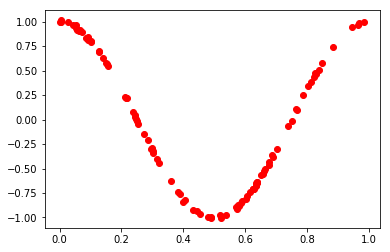

In [69]:
N = 100
d = 10
X, Y = getData(N, 0.01)
print(X.size(), Y.size())
pyplot.plot(X.numpy(),Y.numpy(),'ro')

In [ ]:
XPoly = createNbyDPolynomial(X, N, d)

In [ ]:
mses, epochs, theta = fitDataPlay(XPoly, Y, N, d, 1)

In [ ]:
print(theta)
print(theta.shape)
mse_arr = np.array(mses)
print(len(mse_arr))
epoch_arr = np.array(epochs)
print(len(epoch_arr))
print(mse_arr[-1])

In [ ]:
pyplot.plot(epoch_arr, mse_arr, 'y--')

In [ ]:
YNew = torch.mm(XPoly,theta)
#print(YNew)

In [ ]:
pyplot.plot(X, Y, 'ro')
pyplot.plot(X, YNew, 'go')
pyplot.legend(['Cosine', 'Poly'])